# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from statsmodels.formula.api import ols

# Raw DataFrames

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)

In [3]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)

In [4]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)

# Cleaning steps

In [5]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [6]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

In [7]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [8]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

In [9]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [10]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])

In [11]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

In [12]:
temp_county['dt'] = pd.to_datetime(temp_county['dt'], format='%Y/%m/%d')
temp_county['year'] = temp_county['dt'].dt.year

In [13]:
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820


In [14]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = temp_county_seasons['dt'].dt.month

In [15]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

In [16]:
# Assign United States common regions to the states
## Midwest Region
east_north_central_midwest_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_midwest_region, 'east north central midwest region')

west_north_central_midwest_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_midwest_region, 'west north central midwest region')

## Northeast Region
new_england_northeast_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_northeast_region, 'new england northeast region')

midatlantic_northeast_region = ['NY','PA','NJ']
d4 = dict.fromkeys(midatlantic_northeast_region, 'midatlantic northeast region')

## West Region
pacific_west_region = ['AK','OR','WA','CA','HI']
d5 = dict.fromkeys(pacific_west_region, 'pacific west region')

mountain_west_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d6 = dict.fromkeys(mountain_west_region, 'mountain west region')

## South Region
west_south_central_south_region = ['AR','LA','OK','TX']
d7 = dict.fromkeys(west_south_central_south_region, 'west south central south region')

east_south_central_south_region = ['AL','MS','TN','KY']
d8 = dict.fromkeys(east_south_central_south_region, 'east south central south region')

south_atlantic_south_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_south_region, 'south atlantic south region')


In [17]:
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)

In [18]:
temp_county_region['date_delta'] = (temp_county_region['dt'] - temp_county_region['dt'].min())  / np.timedelta64(1,'D')


#### Join for RF Model

In [19]:
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region,date_delta
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,1,Winter,west south central south region,27819.0
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,2,Winter,west south central south region,27850.0
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,3,Spring,west south central south region,27879.0
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,4,Spring,west south central south region,27910.0
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,5,Spring,west south central south region,27940.0


In [20]:
# disaster data - create year column
disasterdf = disaster_df.copy()
disasterdf['Declaration Date'] = pd.to_datetime(disasterdf['Declaration Date'], format='%m/%d/%Y')
disasterdf['Year'] = disasterdf['Declaration Date'].dt.year

# create region column
disasterdf['Region'] = disasterdf['State'].map(d)

# select columns for merge 
disasterdf = disasterdf[['Declaration Type','Declaration Date','State','County','Disaster Type','Year','Region']]


In [21]:
# disaster data - delete duplicate listing of disasters on the same day (ie. unique disaster per day per state)
disasterdf = disasterdf.drop_duplicates(subset=['Declaration Date','Disaster Type','State','Year']).sort_values('Declaration Date')

# select top 5 disasters
disasterdf = disasterdf[disasterdf['Disaster Type'].isin(['Tornado','Flood','Fire','Hurricane','Storm'])]

# create new disaster count column 
disasterdf['Disaster Count'] = disasterdf['Disaster Type']


In [22]:
# disaster data groupby, get disaster count by region, disaster type, and year
disasterdf = disasterdf.groupby(['Region','Disaster Type','Year'])[['Disaster Count']].count().unstack(fill_value=0).stack().reset_index()
disasterdf

,Region,Disaster Type,Year,Disaster Count
0,east north central midwest region,Fire,1953,0
1,east north central midwest region,Fire,1954,0
2,east north central midwest region,Fire,1955,0
3,east north central midwest region,Fire,1956,0
4,east north central midwest region,Fire,1957,0
5,east north central midwest region,Fire,1958,0
6,east north central midwest region,Fire,1959,0
7,east north central midwest region,Fire,1960,0
8,east north central midwest region,Fire,1961,0
9,east north central midwest region,Fire,1962,0


In [23]:
# copy of temperature data to organize for the join
tempdf = temp_county_region.copy()
tempdf = tempdf.sort_values('dt')

In [24]:
# select columns for join
tempdf = tempdf[['year','AverageTemperature','season','region']]

In [25]:
# temperature data - feature engineer temperature by region and year
tempdf = tempdf.groupby(['region','year']).agg({'AverageTemperature': ['mean','min','max','std']}).unstack(fill_value=0).stack().reset_index()
tempdf.columns = ["_".join(x) for x in tempdf.columns.ravel()]

In [26]:
# rename columns in temperature data frame
tempdf = tempdf.rename(columns={"region_": "region", "year_": "year"});

In [27]:
tempdf.head()

,region,year,AverageTemperature_mean,AverageTemperature_min,AverageTemperature_max,AverageTemperature_std
0,east north central midwest region,1743,3.101138,0.992,5.436,1.215334
1,east north central midwest region,1744,11.849349,-5.782,24.699,8.169105
2,east north central midwest region,1745,0.662147,-7.862,11.562,5.186148
3,east north central midwest region,1750,10.150147,-7.664,26.739,10.191365
4,east north central midwest region,1751,10.872681,-7.814,25.557,10.759784


In [28]:
# create dataframe for seasonal temperature by year and region
season = temp_county_region.pivot_table('AverageTemperature', index=['year','region'], columns='season', fill_value='NaN').reset_index()
season.head()

season,year,region,Fall,Spring,Summer,Winter
0,1743,east north central midwest region,3.10114,NaN,NaN,NaN
1,1743,east south central south region,8.143,NaN,NaN,NaN
2,1743,midatlantic northeast region,3.77578,NaN,NaN,NaN
3,1743,new england northeast region,1.188,NaN,NaN,NaN
4,1743,south atlantic south region,10.9985,NaN,NaN,NaN


In [29]:
# join the temperature dataframe with the seasonal temperatures to obtain more features
join_dataframe = pd.merge(tempdf, season, left_on=['region','year'], right_on=['region','year'], how='left')
join_dataframe

,region,year,AverageTemperature_mean,AverageTemperature_min,AverageTemperature_max,AverageTemperature_std,Fall,Spring,Summer,Winter
0,east north central midwest region,1743,3.101138,0.992,5.436,1.215334,3.10114,NaN,NaN,NaN
1,east north central midwest region,1744,11.849349,-5.782,24.699,8.169105,9.5243,12.7892,21.6998,-2.75593
2,east north central midwest region,1745,0.662147,-7.862,11.562,5.186148,NaN,4.76259,NaN,-3.43829
3,east north central midwest region,1750,10.150147,-7.664,26.739,10.191365,13.1871,9.14032,22.2995,-3.01402
4,east north central midwest region,1751,10.872681,-7.814,25.557,10.759784,16.3001,5.86155,22.1556,-3.75436
5,east north central midwest region,1752,2.954793,-10.788,11.689,6.044789,7.57381,5.73334,NaN,-4.44278
6,east north central midwest region,1753,9.546578,-8.022,25.487,10.000526,10.2772,9.43994,22.1723,-3.70309
7,east north central midwest region,1754,9.693674,-7.825,25.307,10.953768,14.2623,2.34821,21.9211,-3.13099
8,east north central midwest region,1755,6.754024,-8.565,24.163,9.001517,10.1147,8.98146,21.3252,-3.69114
9,east north central midwest region,1756,9.992031,-6.984,25.053,10.556222,10.0938,NaN,21.8625,-1.98023


In [30]:
disasterdf.head()

,Region,Disaster Type,Year,Disaster Count
0,east north central midwest region,Fire,1953,0
1,east north central midwest region,Fire,1954,0
2,east north central midwest region,Fire,1955,0
3,east north central midwest region,Fire,1956,0
4,east north central midwest region,Fire,1957,0


In [31]:
# join temperature and disaster dataframe 
joindf = pd.merge(disasterdf, join_dataframe, left_on=['Region','Year'], right_on=['region','year'], how='left')

In [32]:
# drop duplicate columns
joindf = joindf.drop(columns = ['region','year'])

In [33]:
joindf.head()

,Region,Disaster Type,Year,Disaster Count,AverageTemperature_mean,AverageTemperature_min,AverageTemperature_max,AverageTemperature_std,Fall,Spring,Summer,Winter
0,east north central midwest region,Fire,1953,0,11.046523,-4.808,25.870,9.009154,12.6579,9.05599,22.5851,-0.112862
1,east north central midwest region,Fire,1954,0,10.610394,-6.416,27.563,9.187059,12.1459,8.61549,22.1624,-0.48223
2,east north central midwest region,Fire,1955,0,10.504940,-6.884,27.186,10.275308,11.2949,10.6548,22.8636,-2.79356
3,east north central midwest region,Fire,1956,0,10.129736,-5.804,24.367,9.154006,11.8911,8.14903,21.6039,-1.12514
4,east north central midwest region,Fire,1957,0,10.011848,-10.172,25.552,9.295035,10.6796,9.18855,21.7707,-1.59148


In [34]:
joindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 0 to 2859
Data columns (total 12 columns):
Region                     2860 non-null object
Disaster Type              2860 non-null object
Year                       2860 non-null int64
Disaster Count             2860 non-null int64
AverageTemperature_mean    2684 non-null float64
AverageTemperature_min     2684 non-null float64
AverageTemperature_max     2684 non-null float64
AverageTemperature_std     2684 non-null float64
Fall                       2684 non-null object
Spring                     2684 non-null object
Summer                     2684 non-null object
Winter                     2684 non-null object
dtypes: float64(4), int64(2), object(6)
memory usage: 290.5+ KB


# Statistical Inference

## Average yearly temperature, sorted by season

The question that is being examined is how climate change plays into the the natural disasters in the United States. I am looking at the average yearly temperature and how temperature has been changing by season. 

Text(0.5,1,'Fall')

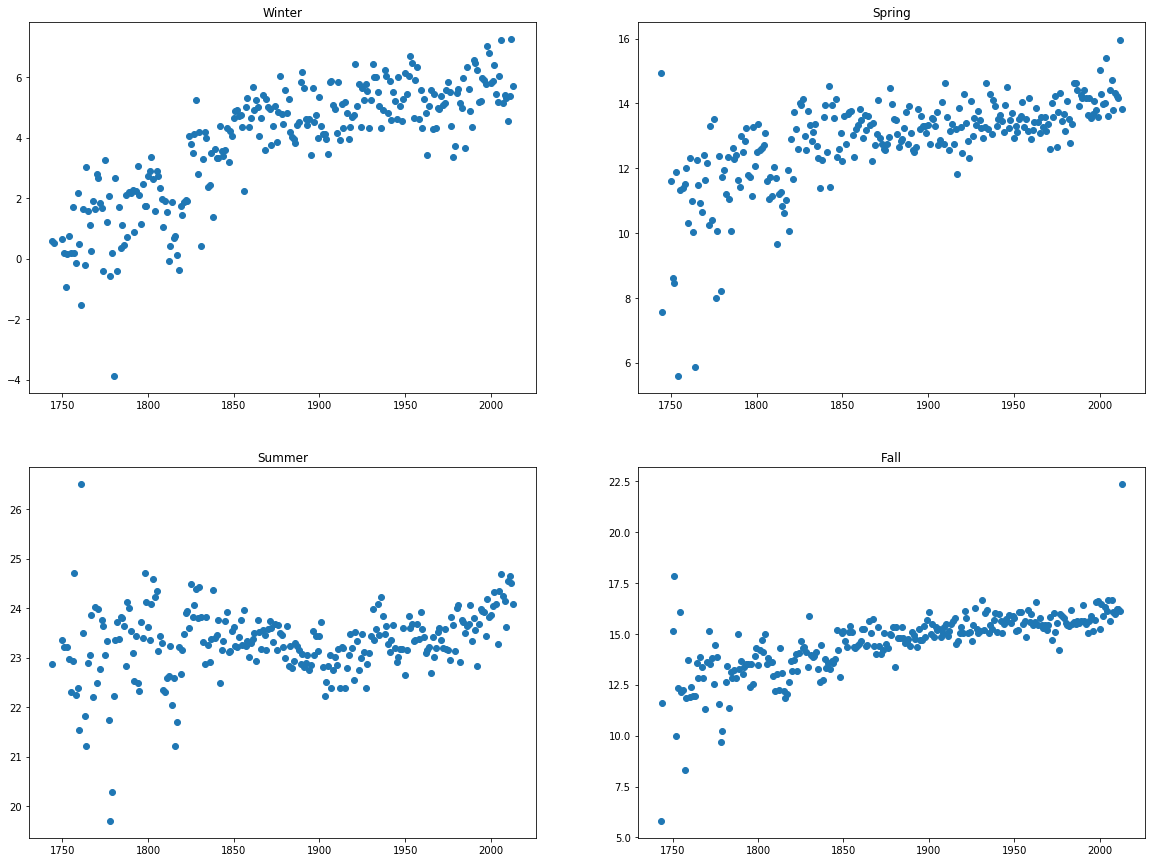

In [35]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[0,0].scatter(winter['year'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')           

spring = temp_county_region[temp_county_region.season == 'Spring'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[0,1].scatter(spring['year'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[1,0].scatter(summer['year'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby(['year']).mean()[['AverageTemperature']].reset_index()
ax[1,1].scatter(fall['year'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')           
                   
           

In [36]:
print('winter corr: ', winter['year'].corr(winter.AverageTemperature),'\n'
      'spring corr: ', spring['year'].corr(spring.AverageTemperature),'\n'
      'summer corr: ', summer['year'].corr(summer.AverageTemperature),'\n'
      'fall corr  : ', fall['year'].corr(fall.AverageTemperature))

winter corr:  0.8185691856309464 
spring corr:  0.6587791341045452 
summer corr:  0.24555088282850218 
fall corr  :  0.7381441619175758


These four scatter plots show the correlation of date and average temperature. Each of the temperature values were averaged over the year, and each season is portrayed. Winter, spring, and fall have strong positive correlations of time and temperature, while summer did not show as strong of a correlation. Summer has a slight curve in the scatterplot and shows a slight positive trend toward the end. There is potential for the summer data to fit a polynomial regression, however I have to be cautious to not overfit. These correlation values are strong, with the exception of summer, and will be further examined for modeling and predicting future temperatures.

### Winter Linear Regression

Next, I will perform a linear regression on all four seasons to determine the p-value and other coefficients for modeling. 

In [37]:
# set the variables to time and temperature
x = winter[['year']].values
y = winter[['AverageTemperature']].values

In [38]:
# using scipy stats linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.020839    intercept: -35.340342    r-squared: 0.670056    p-value: 0.000000


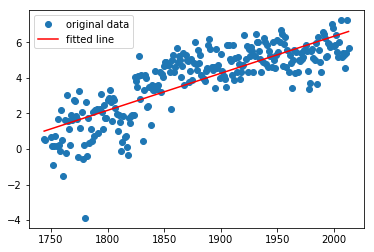

In [39]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### Spring Linear Regression

In [40]:
x = spring[['year']].values
y = spring[['AverageTemperature']].values

In [41]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.011899    intercept: -9.514222    r-squared: 0.433990    p-value: 0.000000


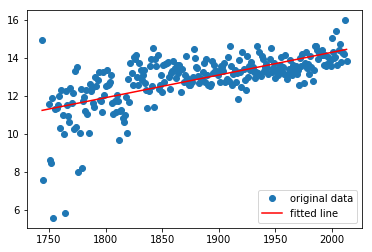

In [42]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### Summer Linear Regression

In [43]:
x = summer[['year']].values
y = summer[['AverageTemperature']].values

In [44]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.002217    intercept: 19.151381    r-squared: 0.060295    p-value: 0.000055


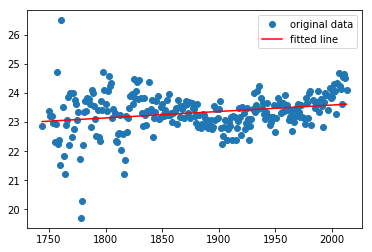

In [45]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### Fall Linear Regression

In [46]:
x = fall[['year']].values
y = fall[['AverageTemperature']].values

In [47]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.014792    intercept: -13.271476    r-squared: 0.544857    p-value: 0.000000


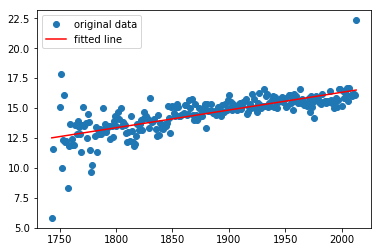

In [48]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

All four seasons show a p-value of 0, which indicates that the null hypothesis can be rejected. In this case, the null hypothesis is that the slope is zero, meaning that the slope that we are seeing for each season is not a coincidence. Thus, these datasets will be used to create linear models for predicting average temperature.

## Average yearly temperature, sorted by region

I will now look at the correlations for average yearly temperatures over time, split by region. I will compare these values to those that are split by season to determine which data to use for modelling. Additionally, the region-specific models may be useful for the disaster data since some disasters are found in specific regions of the United States.

In [49]:
# nine regions of the United States
enc_midwest_region = temp_county_region[temp_county_region['region']=='east north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

esc_south_region = temp_county_region[temp_county_region['region']=='east south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mid_northeast_region = temp_county_region[temp_county_region['region']=='midatlantic northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mt_west_region = temp_county_region[temp_county_region['region']=='mountain west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

ne_northeast_region = temp_county_region[temp_county_region['region']=='new england northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

pac_west_region = temp_county_region[temp_county_region['region']=='pacific west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

sa_south_region = temp_county_region[temp_county_region['region']=='south atlantic south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wnc_midwest_region = temp_county_region[temp_county_region['region']=='west north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wsc_south_region = temp_county_region[temp_county_region['region']=='west south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()


In [50]:
print('enc corr: ', enc_midwest_region['year'].corr(enc_midwest_region.AverageTemperature),'\n'
      'esc corr: ', esc_south_region['year'].corr(esc_south_region.AverageTemperature),'\n'
      'mid corr: ', mid_northeast_region['year'].corr(mid_northeast_region.AverageTemperature),'\n'
      'mt corr: ', mt_west_region['year'].corr(mt_west_region.AverageTemperature),'\n'
      'ne corr: ', ne_northeast_region['year'].corr(ne_northeast_region.AverageTemperature),'\n'
      'pac corr: ', pac_west_region['year'].corr(pac_west_region.AverageTemperature),'\n'
      'sa corr: ', sa_south_region['year'].corr(sa_south_region.AverageTemperature),'\n'
      'wnc corr: ', wnc_midwest_region['year'].corr(wnc_midwest_region.AverageTemperature),'\n'
      'wsc corr: ', wsc_south_region['year'].corr(wsc_south_region.AverageTemperature),'\n')

enc corr:  0.4030379883249252 
esc corr:  0.43415441337079186 
mid corr:  0.48081285359265274 
mt corr:  0.6734878949707309 
ne corr:  0.49294117838291945 
pac corr:  0.6427530117788472 
sa corr:  0.5347502345372169 
wnc corr:  0.5768741511922301 
wsc corr:  0.5638639630474188 



These correlation values are moderately strong, and will potentially be explored if region-specific data is needed. Seeing that the regions have a positive medium-strong correlation with temperature over time in years, I can use the region divisions to model the predicted temperature in these regions and then use that model with the disaster that is likely to be found in that region and determine future information about the disaster data.

## Joined temperature and disaster data

The first five disasters with the most occurences in the United States are: storms, floods, fires, hurricanes, and tornados. I will focus on these disasters to examine the trends in the data, since they make up most of the data.

To view correlations between temperature and disaster I will use the joined dataframe.

In [51]:
# create key to search the join df for unique region/disaster pairs
disasters = joindf['Disaster Type'].unique()
regions = joindf['Region'].unique()

combined = [(s, f) for s in regions for f in disasters]

In [52]:
del combined[29]

In [53]:
joindf = joindf.set_index(['Region','Disaster Type']).dropna()

In [54]:
# disaster count scatter plot
def disaster_corr(key):
    X = joindf.loc[key]['AverageTemperature_mean']
    y = joindf.loc[key]['Disaster Count']
    return X.corr(y)

In [55]:
for k in combined:
    print(k, disaster_corr(k))

('east north central midwest region', 'Fire') 0.15702853839443737
('east north central midwest region', 'Flood') -0.13733788882246076
('east north central midwest region', 'Hurricane') 0.16892208445654822
('east north central midwest region', 'Storm') 0.2897740883964606
('east north central midwest region', 'Tornado') -0.042091798688361465
('east south central south region', 'Fire') 0.1816286571925283
('east south central south region', 'Flood') -0.12124559726473597
('east south central south region', 'Hurricane') 0.2311128490147538
('east south central south region', 'Storm') 0.3232560171171085
('east south central south region', 'Tornado') -0.11089711477801707
('midatlantic northeast region', 'Fire') 0.2639717346519229
('midatlantic northeast region', 'Flood') -0.1725536977615792
('midatlantic northeast region', 'Hurricane') 0.41961364683100655
('midatlantic northeast region', 'Storm') 0.36748271250562947
('midatlantic northeast region', 'Tornado') 0.05834091410034186
('mountain west

These are the correlation values between the average temperature per year and the disaster count for each disaster region pair. The values of interest are those with the highest correlation for a variety of disasters. I will focus on the following for modeling: Mountain West Region / Fire; New England Northeast Region / Storm; and Mid Atlantic Northeast Region / Hurricane.

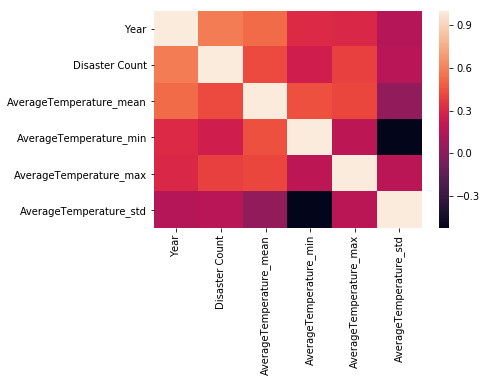

In [56]:
# correlation map for Mountain West Region / Fire
corr = joindf.loc[('mountain west region', 'Fire')].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

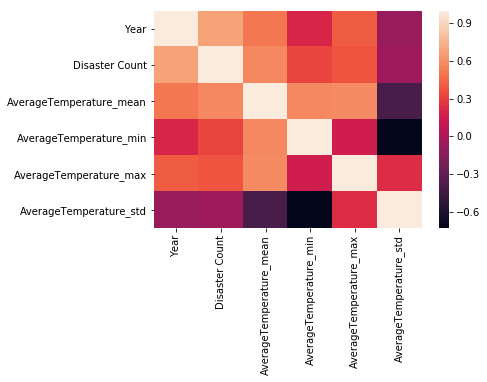

In [57]:
# correlation map for New England Northeast Region / Storm
corr = joindf.loc[('new england northeast region', 'Storm')].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

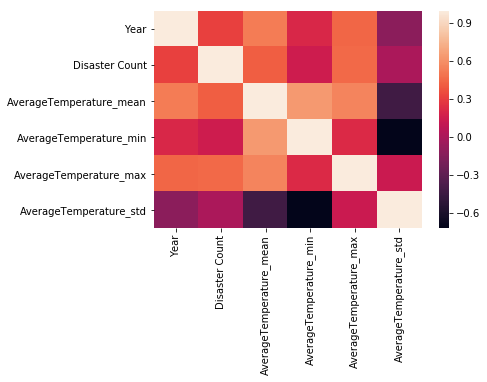

In [58]:
# correlation map for Mid Atlantic Northeast Region / Hurricane
corr = joindf.loc[('midatlantic northeast region', 'Hurricane')].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)